The aim of this notebook is to improve on notebook 7.
This notebook contains:
- Loading Sentinel-2 data and WorldCover data, and saving to a Zarr file using Dask
- Model and dataset definitions for an 11-class Prithvi based classification model based on the WorldCover dataset
- A training function using DDP and `dask_pytorch_ddp` to finetune Prithvi
- Various tests for each component


Things I have done in order:
1. Ice Chunk + DDP + Batch Iterator - Compute Weights
  - This mainly helps with read and write speed of the zarr storage
2. Ice Chunk + DDP + cupy + Dali + dlpack + Batch Iterator
  - Interestingly this doesn't "show up" as Tasks on the Dask dashboard. Having a direct pipe to GPU memory seems to bypass Dask's task tracking 


In [3]:
# Common imports and settings
import os, sys, re
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import numpy as np
# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                                  # https://github.com/opendatacube/odc-geo
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool                  # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from dea_tools.plotting import display_map, rgb    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools

import boto3

# Basic plots
%matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [4]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# The `git.Repo()` part returns the local directory that easi-notebooks has been cloned into
# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
try:
    import git
    repo = git.Repo('.', search_parent_directories=True).working_tree_dir    # Path to this cloned local directory
except (ImportError, git.InvalidGitRepositoryError):
    repo = Path.home() / 'easi-notebooks'    # Reasonable default
    if not repo.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo not in sys.path:
    sys.path.append(str(repo))    # Add the local path to `easi-notebooks` to python

from easi_tools import EasiDefaults
from easi_tools import initialize_dask, xarray_object_size, mostcommon_crs, heading
#from easi_tools.load_s2l2a import load_s2l2a_with_offset
print("EASI librariies loaded successfully.")

EASI librariies loaded successfully.


In [5]:
import planetary_computer
from pystac_client import Client as PClient
import odc.stac
import boto3
import warnings
warnings.filterwarnings('ignore')
from odc.geo.geobox import GeoBox
from odc.geo.geom import box as odc_box
import time as _time
from pystac_client.exceptions import APIError

import zarr

print("Data Loader Libraries Imported Successfully")

Data Loader Libraries Imported Successfully


In [6]:
import torch
from terratorch.registry import BACKBONE_REGISTRY

from dask_pytorch_ddp import dispatch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.multiprocessing as mp
import torch.optim as optim
from datetime import datetime#, timedelta
import json
import torch.distributed as dist
import terratorch
from contextlib import nullcontext
from torch.cuda.amp import autocast, GradScaler
from s3torchconnector import S3Checkpoint
print("DL libraries imported successfully")

DL libraries imported successfully


# Dask Setup

In [17]:
gateway = Gateway()
options = gateway.cluster_options()
# To get GPUs you must specify
options.cuda_worker = True
clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster(cluster_options=options)
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)

NUM_WORKERS = 4
cluster.scale(NUM_WORKERS)
client = cluster.get_client()

print("Cluster Dashboard:", client.dashboard_link)

Connecting to existing cluster: easihub.494fb1b8cc9f4b4a926d0149ba92e2dc
Cluster Dashboard: https://hub.csiro.easi-eo.solutions/services/dask-gateway/clusters/easihub.494fb1b8cc9f4b4a926d0149ba92e2dc/status


In [8]:
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

# Data Prep
We will use the s3 bucket spcified linked to my EASI acount for storing the data.

In [7]:
# === S3 SETUP ===
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
base_prefix = f"{userid}/{project_name}"
s3_base = f"s3://{bucket}/{base_prefix}"

Successfully found configuration for deployment "csiro"


## Data Selection
Here we Specify:
- Regions to Select the data from
- What Label dataset we will be using (in this case World Cover)

In [10]:
from dataclasses import dataclass
from typing import Dict, List, Tuple

@dataclass
class RegionSpec:
    name: str
    bbox: Tuple[float, float, float, float]

@dataclass
class EODataSpec:
    regions: List[RegionSpec]
    seasonal_windows: List[str]
    bands_s2: List[str]          # raw band IDs you load from STAC
    band_names: List[str]        # canonical names in same order as a subset
    band_map: Dict[str, str]     # mapping raw -> canonical
    resolution: int
    output_crs: str
    tile_size: int



In [11]:
#TODO: Change this to file input (JSNO maybe?)

# === CONFIGURATION ===
region_specs = [
    RegionSpec("tasmania_forest_c", [146.5, -42.0, 146.7, -41.8]),
    RegionSpec("tasmania_forest_w", [146.3, -42.0, 146.5, -41.8]),
    RegionSpec("tasmania_forest_e", [146.7, -42.0, 146.9, -41.8]),
    RegionSpec("tasmania_forest_s", [146.5, -42.2, 146.7, -42.0]),
    RegionSpec("vic_agriculture_c", [143.5, -37.0, 143.7, -36.8]),
    RegionSpec("vic_agriculture_w", [143.3, -37.0, 143.5, -36.8]),
    RegionSpec("vic_agriculture_e", [143.7, -37.0, 143.9, -36.8]),
    RegionSpec("vic_agriculture_n", [143.5, -36.8, 143.7, -36.6]),
    RegionSpec("vic_agriculture_s", [143.5, -37.2, 143.7, -37.0]),
    RegionSpec("nsw_coast_c", [150.8, -34.5, 151.0, -34.3]),
    RegionSpec("nsw_coast_n", [150.8, -34.3, 151.0, -34.1]),
    RegionSpec("nsw_coast_s", [150.8, -34.7, 151.0, -34.5]),
    RegionSpec("nsw_coast_w", [150.6, -34.5, 150.8, -34.3]),
    RegionSpec("nsw_coast_e", [151.0, -34.5, 151.2, -34.3]),
    RegionSpec("qld_tropical_c", [145.7, -16.5, 145.9, -16.3]),
    RegionSpec("qld_tropical_n", [145.7, -16.3, 145.9, -16.1]),
    RegionSpec("qld_tropical_s", [145.7, -16.7, 145.9, -16.5]),
    RegionSpec("qld_tropical_w", [145.5, -16.5, 145.7, -16.3]),
    RegionSpec("qld_tropical_e", [145.9, -16.5, 146.1, -16.3]),
    RegionSpec("wa_arid_c", [116.0, -32.0, 116.2, -31.8]),
    RegionSpec("wa_arid_n", [116.0, -31.8, 116.2, -31.6]),
    RegionSpec("wa_arid_s", [116.0, -32.2, 116.2, -32.0]),
    RegionSpec("wa_arid_w", [115.8, -32.0, 116.0, -31.8]),
    RegionSpec("wa_arid_e", [116.2, -32.0, 116.4, -31.8]),
    RegionSpec("sa_mallee_1", [140.5, -34.8, 140.7, -34.6]),
    RegionSpec("sa_mallee_2", [140.7, -34.8, 140.9, -34.6]),
    RegionSpec("nt_savanna_1", [132.0, -14.0, 132.2, -13.8]),
    RegionSpec("nt_savanna_2", [132.2, -14.0, 132.4, -13.8]),
    RegionSpec("qld_inland_pasture_1", [147.0, -25.0, 147.2, -24.8]),
    RegionSpec("qld_inland_pasture_2", [147.2, -25.0, 147.4, -24.8]),
]

spec = EODataSpec(
    regions=region_specs,
    seasonal_windows=[
        "2021-01-01/2021-02-28",
        "2021-06-01/2021-07-31",
        "2021-09-01/2021-10-31",
    ],
    bands_s2=["B02", "B03", "B04", "B8A", "B11", "B12", "SCL"],
    band_names=["blue", "green", "red", "nir", "swir1", "swir2"],
    band_map={
        "B02": "blue",
        "B03": "green",
        "B04": "red",
        "B8A": "nir",
        "B11": "swir1",
        "B12": "swir2",
    },
    resolution=20,
    output_crs="EPSG:3577",
    tile_size=224,
)

catalog = PClient.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

print("Data setup done")

Data setup done


## Processing Individual Locations
Due to Ice Chunk we can now grab each location one by one and continuously write to the one dataset. 
Once again this dataset will contain:
- Train data
- Validation data
We can do a seperate data call for the test dataset later when evaluating.

The Prithvi model we are using prefers everything in 224x224 patches so we will load in a large patches, break them down into 224x224 and save them into the dataset.

In [12]:
# Refractor tested and working
class RegionSampler:
    def sample_patches(
        self,
        features_region: xr.DataArray,  # (band, time, y, x)
        labels_region: xr.DataArray,    # (y, x)
    ) -> list[xr.Dataset]:
        raise NotImplementedError

class GridRegionSampler(RegionSampler):
    def __init__(self, tile_size: int):
        self.tile_size = tile_size

    def sample_patches(self, features_region, labels_region):
        tile_size = self.tile_size
        ny, nx = features_region.sizes["y"], features_region.sizes["x"]
        ny_tiles = ny // tile_size
        nx_tiles = nx // tile_size

        patches = []
        sample_idx = 0
        for iy in range(ny_tiles):
            for ix in range(nx_tiles):
                ys = slice(iy * tile_size, (iy + 1) * tile_size)
                xs = slice(ix * tile_size, (ix + 1) * tile_size)

                feat_patch = features_region.isel(y=ys, x=xs)
                lab_patch = labels_region.isel(y=ys, x=xs)

                feat_patch = feat_patch.assign_coords(
                    y=np.arange(tile_size),
                    x=np.arange(tile_size),
                )
                lab_patch = lab_patch.assign_coords(
                    y=np.arange(tile_size),
                    x=np.arange(tile_size),
                )

                ds = xr.Dataset(
                    {"features": feat_patch, "labels": lab_patch}
                ).expand_dims(sample=[sample_idx])

                patches.append(ds)
                sample_idx += 1

        return patches

In [13]:
import icechunk as ic
from icechunk.xarray import to_icechunk


def safe_search_items(catalog, collections, bbox, datetime=None, query=None,
                      max_items=150, retries=3):
    for i in range(retries):
        t0 = _time.time()
        print(f"  STAC search start (try {i+1}/{retries}) "
              f"{collections} {datetime} bbox={bbox}")
        try:
            search = catalog.search(
                collections=collections,
                bbox=bbox,
                datetime=datetime,
                query=query,
                max_items=max_items,
            )
            items = search.item_collection()
            dt = _time.time() - t0
            return items
        except APIError as e:
            dt = _time.time() - t0
            print(f"  STAC search failed after {dt:.1f}s: {e}")
            msg = str(e)
            if "maximum allowed time" in msg and i < retries - 1:
                wait = 2 ** i
                print(f"  STAC timeout, retry {i+1}/{retries} after {wait}s...")
                time.sleep(wait)
                continue
            raise

# --- Region-level geobox and loaders ---

def make_region_geobox(spec: EODataSpec, bbox):
    """
    Full-region GeoBox; patches will be spec.tile_size later via slicing.
    """
    geom_4326 = odc_box(bbox[0], bbox[1], bbox[2], bbox[3], crs="EPSG:4326")
    geom_3577 = geom_4326.to_crs(spec.output_crs)
    return GeoBox.from_bbox(
        geom_3577.boundingbox,
        crs=spec.output_crs,
        resolution=spec.resolution,
    )


def load_region_labels(catalog, spec: EODataSpec, bbox):
    geobox = make_region_geobox(spec, bbox)
    items = safe_search_items(
        catalog=catalog,
        collections=["esa-worldcover"],
        bbox=bbox,
        max_items=25,
    )
    if not items:
        return None, geobox

    ds = odc.stac.load(
        items,
        bands=["map"],
        geobox=geobox,
        chunks={"y": 1024, "x": 1024},
        resampling="nearest",
        fail_on_error=False,
    )
    labels = ds["map"].isel(time=0, drop=True).fillna(255).astype("uint8")
    return labels, geobox


    
def load_region_season(catalog, spec: EODataSpec, bbox, time_range, geobox):
    try:
        items = safe_search_items(
            catalog=catalog,
            collections=["sentinel-2-l2a"],
            bbox=bbox,
            datetime=time_range,
            query={"eo:cloud_cover": {"lt": 90}},
            max_items=100,
        )
    except APIError as e:
        print(f"  [season {time_range}] STAC search failed: {e}")
        return None

    if not items:
        return None

    ds = odc.stac.load(
        items,
        bands=spec.bands_s2,
        geobox=geobox,
        chunks={"y": 1024, "x": 1024},
        fail_on_error=False,
    )
    if ds.sizes.get("time", 0) == 0:
        return None

    if "SCL" in ds:
        qa = ds["SCL"]
        valid = ((qa == 4) | (qa == 5) | (qa == 6) |
                 (qa == 7) | (qa == 2) | (qa == 11))
        masked = ds.where(valid)
        comp = masked.median(dim="time")
        comp = comp.fillna(masked.min(dim="time")).fillna(0)
    else:
        comp = ds.median(dim="time").fillna(0)

    # Now use the spec-driven band selection/rename
    raw_band_ids = list(spec.band_map.keys())
    comp = comp[raw_band_ids]
    comp = comp.rename(spec.band_map).astype("uint16")
    return comp


def region_to_patches(
    catalog,
    spec: EODataSpec,
    region: RegionSpec,
    sampler: RegionSampler,
    ):
    bbox = region.bbox

    labels_region, geobox = load_region_labels(catalog, spec, bbox)
    if labels_region is None:
        print(f"  No labels for {region.name}, skipping.")
        return []

    comps = []
    for t in spec.seasonal_windows:
        comp = load_region_season(catalog, spec, bbox, t, geobox)
        if comp is None:
            print(f"  Skipping {region.name} for window {t} (no data / STAC error)")
            return []
        comps.append(comp)

    features_region = xr.concat(comps, dim="time")
    features_region = features_region.to_array("band").transpose("band", "time", "y", "x")

    return sampler.sample_patches(features_region, labels_region)


# --- Per-region write to temporary Zarrs ---
class STACIceChunkBuilder:
    def __init__(
        self,
        catalog,
        bucket: str,
        base_prefix: str,
        dataset_name: str,
        spec: EODataSpec,
        sampler: RegionSampler | None = None,
        region: str | None = "ap-southeast-2",
    ):
        self.catalog = catalog
        self.spec = spec
        self.bucket = bucket
        self.base_prefix = base_prefix
        self.dataset_name = dataset_name
        self.sampler = sampler or GridRegionSampler(tile_size=spec.tile_size)

        # Each dataset gets its own clean S3 prefix for the Icechunk repo
        self.repo_prefix = f"{base_prefix}/{dataset_name}-icechunk"
        session = boto3.session.Session()
        # Configure Icechunk S3 storage and repo once in __init__
        self.storage = ic.s3_storage(
            bucket=self.bucket,
            prefix=self.repo_prefix,
            region=region,
            from_env=True,   # uses your usual AWS creds / role
        )
        # open_or_create is the recommended pattern for scripts rerun many times
        self.repo = ic.Repository.open_or_create(self.storage)  # [web:1][web:64]

        

    @property
    def s3_base(self) -> str:
        return f"s3://{self.bucket}/{self.base_prefix}"
    
    def cleanup_repo(self):
        fs = s3fs.S3FileSystem(anon=False)
        path = f"s3://{self.bucket}/{self.repo_prefix}"
        print("Deleting Icechunk repo prefix:", path)
        fs.rm(path, recursive=True)
        
    # thin wrapper around your existing function-based helper
    def region_to_patches(self, region: RegionSpec):
        return region_to_patches(self.catalog, self.spec, region, self.sampler)


    def build(self, branch: str = "main", resume: bool = True) -> str:
        """
        Incrementally build a single Icechunk-backed dataset on S3.
    
        If resume=True:
          - Detect an existing dataset on this branch.
          - Skip regions already written (tracked via 'regions_done').
          - Append only missing regions along 'sample'.
    
        If resume=False:
          - Overwrite from scratch (first write uses mode='w').
    
        Returns the final snapshot_id string for this build.
        """
        total_samples = 0
        last_snapshot_id: str | None = None
        regions_done: set[str] = set()
    
        if resume:
            try:
                ro_session = self.repo.readonly_session(branch)
                ds_existing = xr.open_zarr(
                    ro_session.store,
                    consolidated=False,   # no engine kw here
                )
            except Exception as e:
                raise RuntimeError(
                    f"resume=True but no readable dataset found on branch '{branch}'. "
                    "Run once with resume=False (fresh build) or clean the repo prefix."
                ) from e
            else:
                total_samples = int(ds_existing.sizes.get("sample", 0) or 0)
                regions_done = set(ds_existing.attrs.get("regions_done", []))
                print(
                    f"[resume] Found existing dataset on '{branch}': "
                    f"{total_samples} samples, {len(regions_done)} regions_done."
                )
            first_region = False
        else:
            print(
                f"resume=False: will overwrite any existing dataset on branch '{branch}' "
                f"(first write uses mode='w')."
            )
            first_region = True
    
        for region in self.spec.regions:
            if resume and region.name in regions_done:
                print(f"  Region {region.name} already present, skipping.")
                continue
    
            print(f"\n=== Building patches for {region.name} ===")
            try:
                patches = self.region_to_patches(region)
            except APIError as e:
                print(f"  Skipping {region.name} due to STAC API error: {e}")
                continue
    
            if not patches:
                print(f"  No patches for {region.name}, skipping.")
                continue
    
            ds_region = xr.concat(patches, dim="sample")

            # ---- TRAINING-OPTIMIZED VIEW: drop 'band' variable but keep names ----
            # Will help later
            if "band" in ds_region.coords:
                band_names = ds_region.coords["band"].values.tolist()  # ['blue','green',...]
                ds_region = ds_region.drop_vars("band")                # remove object coord var
                ds_region.attrs["bands"] = band_names                  # keep mapping in attrs
            else:
                # Fallback: still set bands from spec if coord missing
                ds_region.attrs["bands"] = self.spec.band_names

            
            ds_region = ds_region.chunk({
                "sample": 8,
                "time": -1,
                "band": -1,
                "y": self.spec.tile_size,
                "x": self.spec.tile_size,
            })
            ds_region.attrs["n_time_steps"] = len(self.spec.seasonal_windows)
            ds_region.attrs["bands"] = self.spec.band_names
    
            print(f"  Writing {ds_region.sizes['sample']} samples from {region.name}")
    
            # New writable session for this write [web:6]
            session = self.repo.writable_session(branch)
    
            if first_region:
                # Only ever used on a true fresh build (resume=False) [web:6][web:55]
                to_icechunk(ds_region, session, mode="w")
                first_region = False
            else:
                # Append along 'sample' with automatic chunk alignment [web:6][web:55]
                to_icechunk(
                    ds_region,
                    session,
                    append_dim="sample",
                    align_chunks=True,
                )
    
            # Update regions_done within this transaction
            regions_done.add(region.name)
            root = zarr.open_group(session.store, mode="r+")
            root.attrs["regions_done"] = list(regions_done)
    
            last_snapshot_id = session.commit(
                f"append {ds_region.sizes['sample']} samples from {region.name}"
            )
            total_samples += ds_region.sizes["sample"]
    
        if last_snapshot_id is None:
            if resume:
                # Nothing new to write; dataset already complete for this spec
                print(
                    "[resume] No new regions were written; all regions are already present. "
                    "Returning current branch tip."
                )
                # Return the current branch tip snapshot
                ro_session = self.repo.readonly_session(branch)
                return ro_session.snapshot_id  # or whatever your caller expects
            else:
                # Fresh build with no data is probably a real problem
                raise RuntimeError("No regions produced data; nothing was written.")
        print(f"[Done] Icechunk repo s3://{self.bucket}/{self.repo_prefix}")
        print(f"Total samples (this branch view): {total_samples}")
        print(f"Final snapshot id: {last_snapshot_id}")
        return last_snapshot_id


## Creating the dataset
Depending on your image, you may have to install ice chunk onto your cluster.

In [21]:
client.restart()

print("Installing icechunk (and zarr>=3) on all workers...")
client.run(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'zarr>=3.0.8', 'icechunk'])"
))

print("Installing icechunk (and zarr>=3) on the Scheduler...")
client.run_on_scheduler(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'zarr>=3.0.8', 'icechunk'])"
))

print("Installation initiated on both Scheduler and Workers. Now retry the Icechunk build.")


Installing icechunk (and zarr>=3) on all workers...
Installing icechunk (and zarr>=3) on the Scheduler...
Installation initiated on both Scheduler and Workers. Now retry the Icechunk build.


Instead of a file location we will get a snapshot id, if we want to go back and read the dataset we will use that snapshot id to do so.

In [22]:
print("Building incremental Icechunk dataset...")

sampler = GridRegionSampler(tile_size=224)

# Choose a logical dataset name (no need for .zarr suffix)
dataset_name = "training_dataset_v4"

builder = STACIceChunkBuilder(
    catalog=catalog,
    bucket=bucket,
    base_prefix=base_prefix,
    dataset_name=dataset_name,
    spec=spec,
    sampler=sampler,
)

snapshot_id = builder.build(branch="main", resume=True)
print("Snapshot ID:", snapshot_id)

# For later use in training:
print("Repo prefix:", builder.repo_prefix)   # e.g. f"{base_prefix}/{dataset_name}-icechunk"


Building incremental Icechunk dataset...
[resume] Found existing dataset on 'main': 627 samples, 30 regions_done.
  Region tasmania_forest_c already present, skipping.
  Region tasmania_forest_w already present, skipping.
  Region tasmania_forest_e already present, skipping.
  Region tasmania_forest_s already present, skipping.
  Region vic_agriculture_c already present, skipping.
  Region vic_agriculture_w already present, skipping.
  Region vic_agriculture_e already present, skipping.
  Region vic_agriculture_n already present, skipping.
  Region vic_agriculture_s already present, skipping.
  Region nsw_coast_c already present, skipping.
  Region nsw_coast_n already present, skipping.
  Region nsw_coast_s already present, skipping.
  Region nsw_coast_w already present, skipping.
  Region nsw_coast_e already present, skipping.
  Region qld_tropical_c already present, skipping.
  Region qld_tropical_n already present, skipping.
  Region qld_tropical_s already present, skipping.
  Regio

#### Optional Step (1)
You can then clean up all the temp (individual) datasets if you like

In [86]:
import s3fs

fs = s3fs.S3FileSystem(anon=False)

# Full S3 path to the Icechunk repo prefix
icechunk_prefix = f"s3://{bucket}/{builder.repo_prefix}"

print("Deleting Icechunk repo prefix:", icechunk_prefix)
fs.rm(icechunk_prefix, recursive=True)


Deleting Icechunk repo prefix: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v4-icechunk


[]

#### Optional Step (2)
You can check the data format and if everything was saved correctly by graphing a few samples locally.
You should check:
- Demensions of the dataset (sample: 627, band: 6, time: 3, y: 224, x: 224)
  - bands, x and y should match the model input you are using (For prithvi 6 bands, and 224x224 patches)
- Label Dimensions and Values
  - Dimensions should match the 224x224 patches
  - Values should not contain NaN and be multiples of 10 from 10 to 100 or 95
  - This is also a sanity check to see if your labels line up with the ESI patches spatially 



Successfully found configuration for deployment "csiro"
⏳ Verifying Icechunk-backed dataset...
<xarray.DataArray 'features' (sample: 627, band: 6, time: 3, y: 224, x: 224)> Size: 1GB
dask.array<open_dataset-features, shape=(627, 6, 3, 224, 224), dtype=uint16, chunksize=(8, 6, 3, 224, 224), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) int64 2kB 0 1 2 3 4 5 6 7 ... 217 218 219 220 221 222 223
  * x            (x) int64 2kB 0 1 2 3 4 5 6 7 ... 217 218 219 220 221 222 223
    spatial_ref  int32 4B ...
  * sample       (sample) int64 5kB 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
Dimensions without coordinates: band, time
Dataset loaded. Dimensions:
  Samples (N): 627
  Time Steps (T): 3
  Spatial (Y, X): 224, 224
  Bands: ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
DEBUG: Sample 0 unique label values: [10 30 60 80 90]
Processing Sample 0...
DEBUG: Sample 1 unique label values: [10 30 60 80 90]
Processing Sample 1...


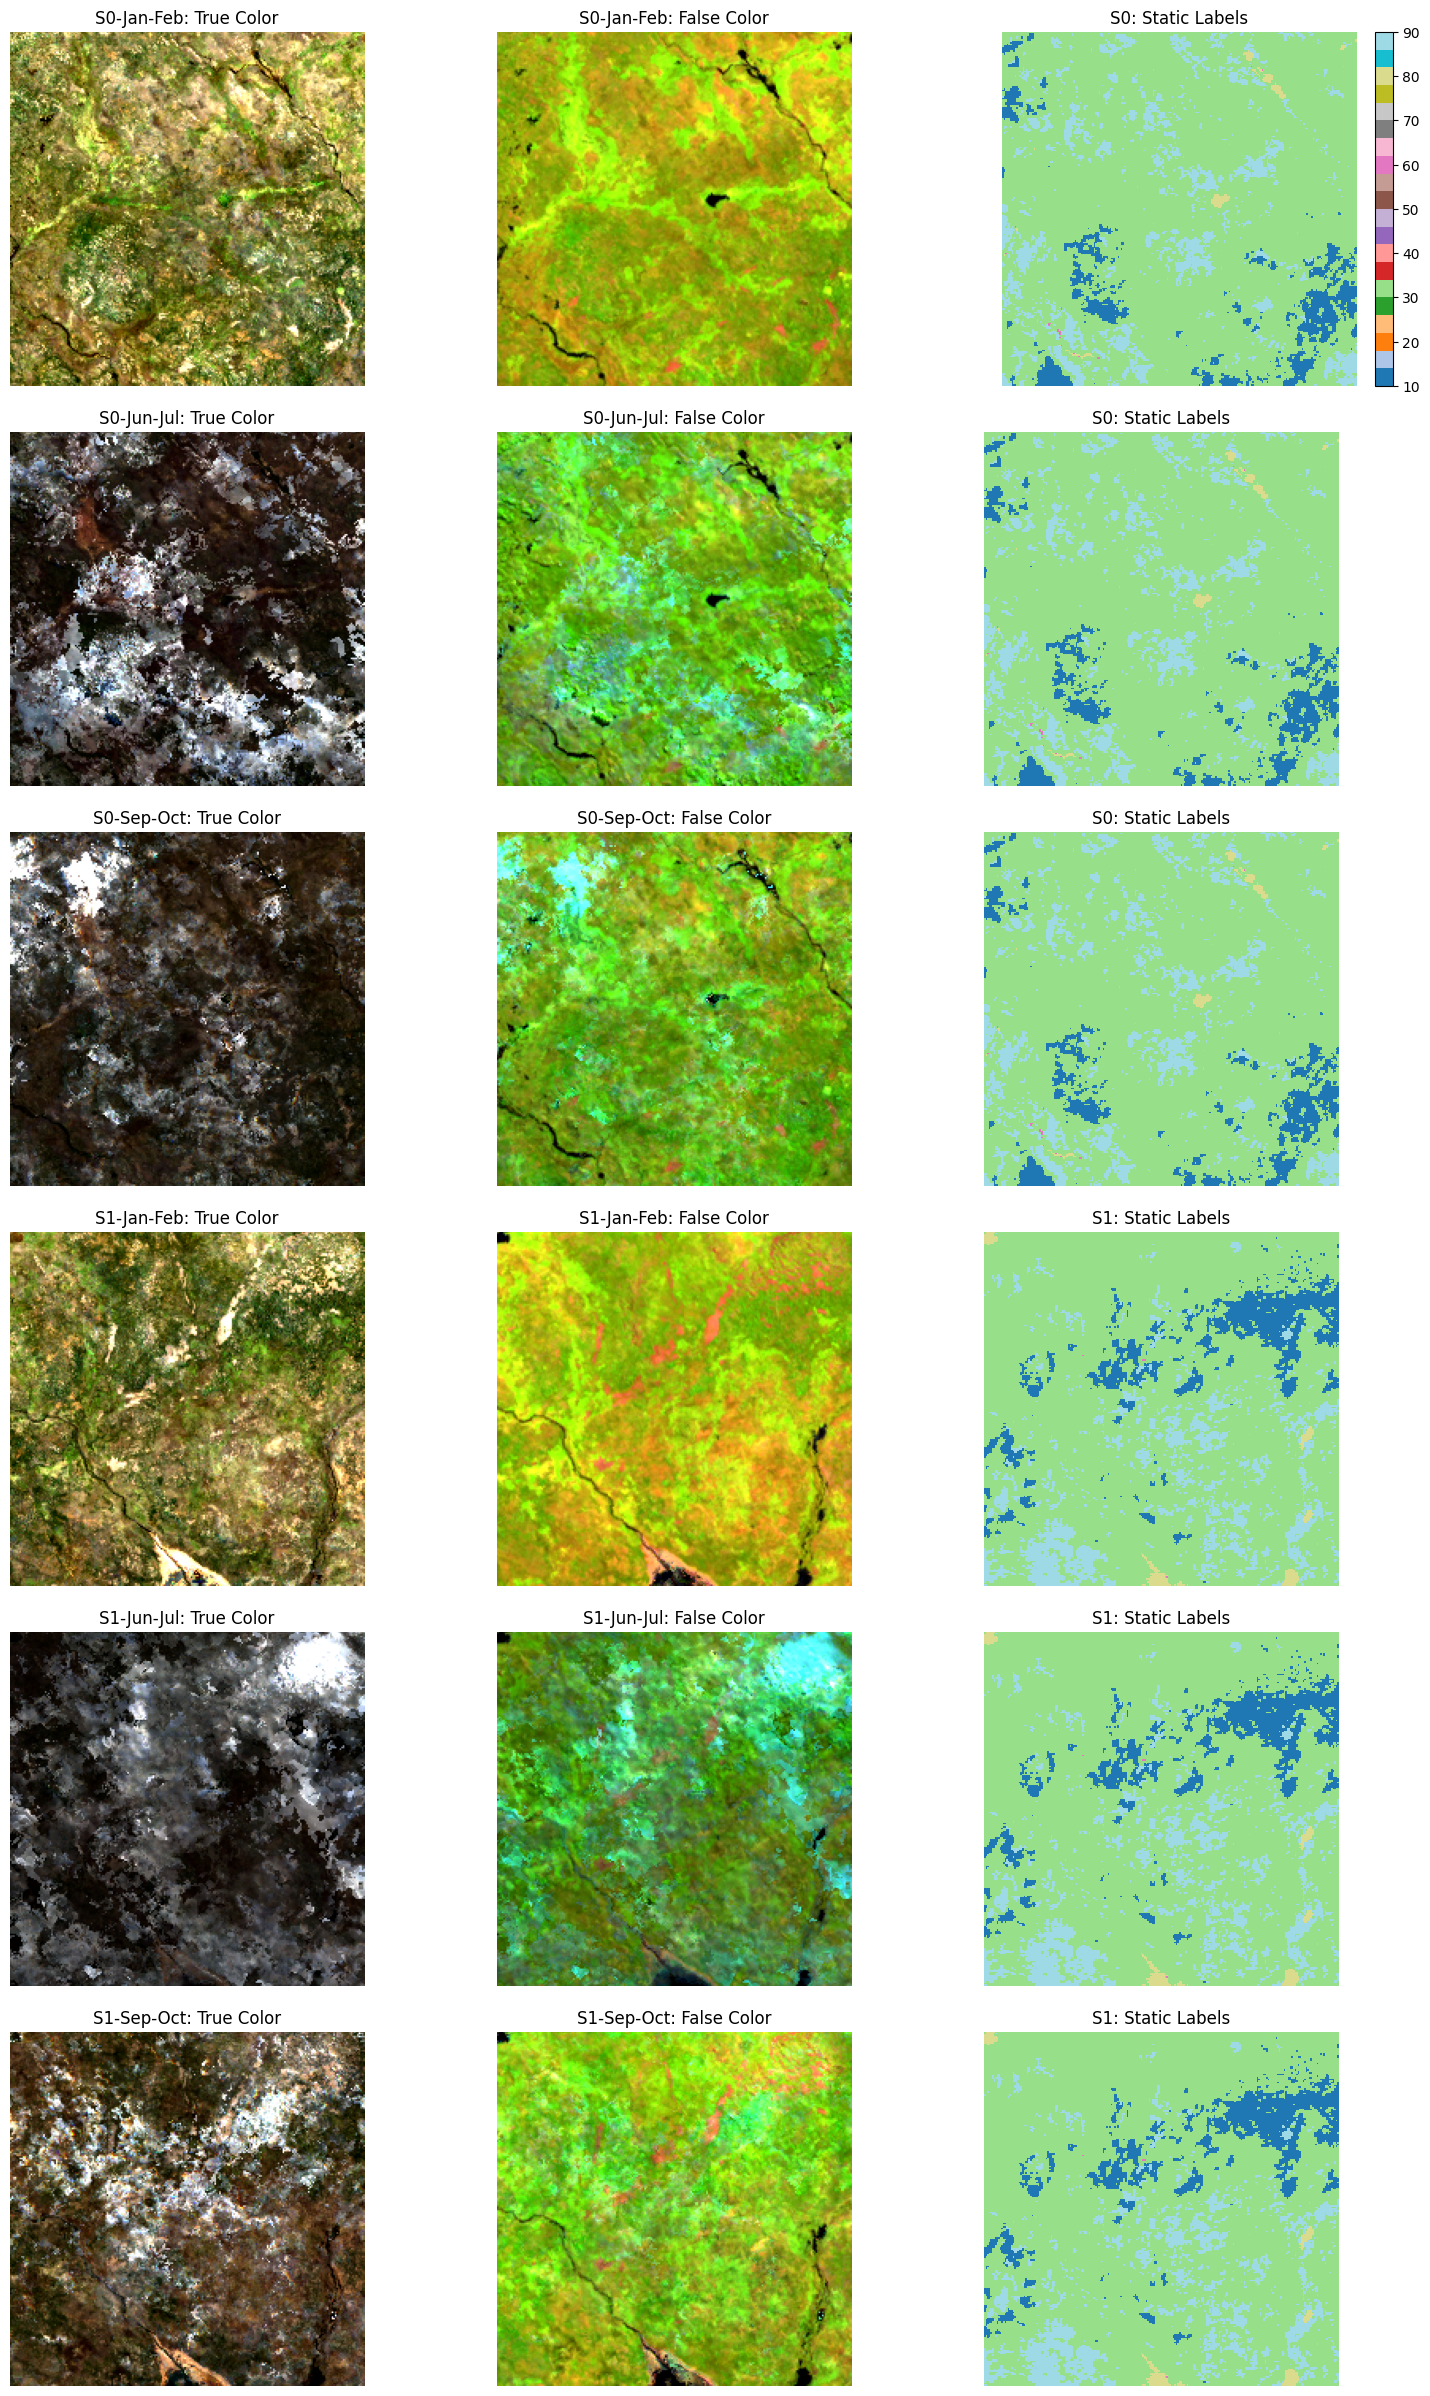

In [23]:
# Basic testing script to see that saving the data worked, TODO: use hvplot for better efficiency
import matplotlib.pyplot as plt
import dask.distributed

import boto3
import icechunk as ic
import xarray as xr

easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_v4"
repo_prefix = f"{userid}/{project_name}/{dataset_name}-icechunk"

# Region (same as in the builder)
session_aws = boto3.session.Session()
region = session_aws.region_name or "ap-southeast-2"

print("⏳ Verifying Icechunk-backed dataset...")
try:
    storage = ic.s3_storage(
        bucket=bucket,
        prefix=repo_prefix,
        region=region,
        from_env=True,
    )
    repo = ic.Repository.open(storage)

    # Just use the tip of main for a quick check
    session = repo.readonly_session(branch="main")

    # session.store is a normal Zarr v3 store
    ds = xr.open_zarr(session.store, consolidated=False, chunks={})
except Exception as e:
    print(f"⚠️ Error loading Icechunk dataset: {e}")
    raise


features = ds["features"]
labels = ds["labels"]
print(features)

num_samples = ds.sizes.get('sample')
n_time_steps = ds.sizes.get('time')

if num_samples is None or n_time_steps != 3:
    print("\n❌ CRITICAL ERROR: The loaded Zarr file still does NOT contain the 'sample' dimension or the correct 'time' size (3).")
    print("Please re-run the data generation pipeline to ensure the correct multi-sample Zarr is saved before proceeding.")
    # Exit or raise an exception to prevent training on bad data
    raise KeyError("Loaded Zarr file is structurally incorrect. Expected dimensions 'sample' and 'time' size 3.")

print(f"Dataset loaded. Dimensions:")
print(f"  Samples (N): {num_samples}")
print(f"  Time Steps (T): {n_time_steps}")
print(f"  Spatial (Y, X): {features.sizes['y']}, {features.sizes['x']}")

# --- 2. Config & Helpers ---
# Band names are now coordinates thanks to the saving logic
band_names = list(ds.attrs["bands"])
print(f"  Bands: {band_names}")
band_index = {name: i for i, name in enumerate(band_names)}
def get_rgb(data_array, bands_list):
    """
    Extracts bands for RGB from a DataArray, assuming the order (B, T, Y, X).
    """
    stack = []
    
    # 1. Extraction (Still the same, but now operating on the first dim B)
    for b in bands_list:
        idx = band_index[b]              # get index for this band name
        band_data = data_array.isel(band=idx)  # (time, y, x); no .sel(band=b)
        stack.append(band_data)
        
    # Stack along a new 'color' dimension. Output shape: (Color, T, Y, X)
    img = xr.concat(stack, dim="color").values.astype('float32')

    # 2. DN Scaling Correction (Scale from uint16 DNs to 0.0-1.0 float range)
    img = img / 10000.0
    img = np.nan_to_num(img, nan=0.0)
    
    # 3. Final Transpose: (Color, T, Y, X) -> (T, Y, X, Color) for plotting
    # Plotting requires (Time, Height, Width, Color)
    img = np.transpose(img, (1, 2, 3, 0)) 
    
    # Check if all images are empty (all zeros)
    if img.max() == 0:
        return None 
        
    # Contrast Stretch - apply stretching to each time step independently
    # The loop is now simpler as 'img' is already (T, Y, X, Color)
    for t in range(img.shape[0]):
        time_slice = img[t, :, :, :]
        valid_pixels = time_slice[time_slice > 0]
        
        if valid_pixels.size > 0:
            p2, p98 = np.percentile(valid_pixels, (2, 98))
            if p98 > p2:
                img[t, :, :, :] = (time_slice - p2) / (p98 - p2)
                        
    return np.clip(img, 0, 1)

# --- 3. Dynamic Plotting Loop ---

# Iterate over SAMPLES, not time steps.
rows = num_samples * n_time_steps 
cols = 3 # RGB, False Color, Labels

plt.figure(figsize=(15, 4 * rows))

plot_idx = 1
season_names = ["Jan-Feb", "Jun-Jul", "Sep-Oct"] # Names from seasonal_windows

for s in range(2):
    # Select a single sample and compute its features and label.
    # .compute() here will read data off S3, potentially distributively if
    # the dask client is still running, which is appropriate for verification.
    sample_features = features.isel(sample=s).compute()
    sample_label = labels.isel(sample=s).compute()
    # Since the labels are static per sample (no 'time' dimension), we plot it once
    label_np = sample_label.values
    
    # 🚨 DEBUGGING STEP: Print unique values
    unique_vals = np.unique(label_np)
    print(f"DEBUG: Sample {s} unique label values: {unique_vals}")
    # ----------------------------------------
    # Check for valid data across all time steps in this sample
    # (Checking the max of the entire sample array is a quick check)
    if sample_features.values.max() == 0:
        print(f"⚠️ Sample {s} appears empty (all zeros). Skipping.")
        continue

    # Process all time steps for this sample
    print(f"Processing Sample {s}...")

    # Generate Images for all time steps at once
    # rgb_stack: (T, Y, X, Color)
    rgb_stack = get_rgb(sample_features, ['red', 'green', 'blue'])
    fc_stack  = get_rgb(sample_features, ['swir1', 'nir', 'red'])

    if rgb_stack is None:
        print(f"⚠️ Skipping Sample {s}: RGB stack failed.")
        continue
    
    # Since the labels are static per sample (no 'time' dimension), we plot it once
    label_np = sample_label.values
    
    for t in range(n_time_steps):
        time_name = season_names[t] if t < len(season_names) else f"Time {t}"
        
        # Plot RGB
        ax1 = plt.subplot(rows, cols, plot_idx)
        ax1.imshow(rgb_stack[t, :, :, :])
        ax1.set_title(f"S{s}-{time_name}: True Color")
        ax1.axis('off')
        plot_idx += 1

        # Plot False Color
        ax2 = plt.subplot(rows, cols, plot_idx)
        ax2.imshow(fc_stack[t, :, :, :])
        ax2.set_title(f"S{s}-{time_name}: False Color")
        ax2.axis('off')
        plot_idx += 1

        # Plot Labels (Only plot on the last column, which should be the same for all time steps)
        ax3 = plt.subplot(rows, cols, plot_idx)
        
        # The labels (WorldCover) are 2D (Y, X), but we repeat the plot for each time step for alignment.
        # Mask out background (0) and nodata (255) for better visualization.
        masked_lbl = np.ma.masked_where(label_np == 255, label_np)
        
        # We need a new colormap instance for consistency if plotting multiple times
        im = ax3.imshow(masked_lbl, cmap='tab20', interpolation='nearest')
        
        # Add colorbar only once for the entire set of label plots (e.g., first time step of the first sample)
        if s == 0 and t == 0: 
            plt.colorbar(im, fraction=0.046, pad=0.04)
            
        # Title only needs to be "Labels" once, or be more specific
        ax3.set_title(f"S{s}: Static Labels")
        ax3.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.show()


In [167]:
client.close()
cluster.shutdown()

# Fine Tuning Setup
We want to define:
- The model we will be fine tuning
- The dataset that will read from the s3 Bucket and feed data to the model during training
Both the model and dataset will usually depend on your specific use case but some genera things:
- Make sure to freeze tha backbone of the model
- Make sure the forward pass fits you dataset dims or vice versa
- Do any transformations you need within the dataset

For this Prithvi Model I have:
- Loadeed in the bakcbone
- Freeze the weights
- Added a decoader head
- A robust forward pass that goes through the backbone and to the new head

In [71]:
class PrithviBackbone(nn.Module):
    def __init__(self, embed_dim=1024, freeze=True, num_frames=3):
        super().__init__()
        self.encoder = BACKBONE_REGISTRY.build(
            "prithvi_eo_v2_300",
            pretrained=True,
            num_frames=num_frames,
        )
        if freeze:
            for p in self.encoder.parameters():
                p.requires_grad = False
        self.embed_dim = embed_dim

    def forward(self, x):
        # x: (B, C, T, H, W)
        assert x.dim() == 5
        B, C, T, H, W = x.shape

        features = self.encoder(x)
        if isinstance(features, (list, tuple)):
            features = features[-1]  # (B, L, C2)

        if features.dim() == 3:
            if features.shape[1] % (T * (H // 16) * (W // 16)) == 1:
                features = features[:, 1:, :]

            B2, L, C2 = features.shape
            t_patches = T
            h_patches = H // 16
            w_patches = W // 16
            assert L == t_patches * h_patches * w_patches

            features = features.view(B2, t_patches, h_patches, w_patches, C2)
            features = features.mean(dim=1)            # (B, H_p, W_p, C2)
            features = features.permute(0, 3, 1, 2)    # (B, C2, H_p, W_p)

        return features, (H, W)  # 2D feature map + original spatial size



class SegmentationHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(128, num_classes, kernel_size=1),
        )

    def forward(self, features, orig_hw):
        H, W = orig_hw
        logits = self.decode(features)
        logits = nn.functional.interpolate(
            logits, size=(H, W), mode="bilinear", align_corners=False
        )
        return logits



class PrithviSegmentation(nn.Module):
    def __init__(self, num_classes=11, freeze_backbone=True):
        super().__init__()
        self.backbone = PrithviBackbone(embed_dim=1024, freeze=freeze_backbone)
        self.head = SegmentationHead(in_channels=1024, num_classes=num_classes)

    def forward(self, x):
        features, orig_hw = self.backbone(x)
        logits = self.head(features, orig_hw)
        return logits

In [72]:
# # # Test for dataset design
# model = BACKBONE_REGISTRY.build("prithvi_eo_v2_300", pretrained=True, num_frames=3)
# x_dummy = torch.randn(2, 6, 3, 224, 224)  # B=2, C=6 bands, T=3, H=W=224
# out = model(x_dummy)
# print(type(out))
# if isinstance(out, (list, tuple)):
#     for i, o in enumerate(out):
#         print(i, o.shape)
# else:
#     print(out.shape)


To make sure your dataset and model definition are correct you can run the above to chekc the input and output shape. Then you can build you decoder and dataset around that.

For this dataset we:
- Map the world Cover outputs to nicer class values
- Filter out any invalid values
- Convert to tensors
To help generalise the dataset, all datasets should return in the form of a dict

In [73]:
class LabelMapper:
    def map(self, raw_labels: np.ndarray) -> np.ndarray:
        raise NotImplementedError
class WorldCoverLabelMapper(LabelMapper):
    def __init__(self, num_classes=11, ignore_index=255):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.code_map = {
            10: 0, 20: 1, 30: 2, 40: 3, 50: 4,
            60: 5, 70: 6, 80: 7, 90: 8, 95: 9, 100: 10,
        }

    def map(self, raw_labels: np.ndarray) -> np.ndarray:
        y = raw_labels.copy()
        y_mapped = np.full_like(y, fill_value=self.ignore_index, dtype=np.int64)
        for wc_code, cls_idx in self.code_map.items():
            y_mapped[y == wc_code] = cls_idx
        y_mapped[np.isnan(y)] = self.ignore_index
        return y_mapped.astype(np.int64)


For some reason, the itterator doesn't want to read as `cup.array`, prefers `numpy.array`

In [ ]:
from torch.utils.data import get_worker_info

class ZarrGPUWorldCover(torch.utils.data.Dataset):
    def __init__(self, bucket, repo_prefix, snapshot_id=None,
                 branch="main", label_mapper=None, region="ap-southeast-2"):
        self.bucket = bucket
        self.repo_prefix = repo_prefix
        self.snapshot_id = snapshot_id
        self.branch = branch
        self.region = region
        self.label_mapper = label_mapper or WorldCoverLabelMapper()
        self._feats = None
        self._labels = None
        self._n = None
        self.patch_size = None

    def _lazy_init(self):
        if self._feats is not None:
            return
        storage = ic.s3_storage(bucket=self.bucket, prefix=self.repo_prefix,
                                region=self.region, from_env=True)
        repo = ic.Repository.open(storage)
        if self.snapshot_id is not None:
            sess = repo.readonly_session(snapshot_id=self.snapshot_id)
        else:
            sess = repo.readonly_session(branch=self.branch)

        with zarr.config.enable_gpu():
            root = zarr.open_group(store=sess.store, mode="r")
            self._feats = root["features"]
            self._labels = root["labels"]

        self._n = self._feats.shape[0]
        h, w = self._feats.shape[-2], self._feats.shape[-1]
        self.patch_size = (h, w)

    def __len__(self):
        self._lazy_init()
        return self._n

    def __getitem__(self, idx):
        self._lazy_init()
        x_cu = self._feats[idx]
        if not isinstance(x_cu, cp.ndarray):
            x = torch.from_numpy(np.asarray(x_cu)).float()
        else:
            x = dlpack.from_dlpack(x_cu.toDlpack()).float()

        y_raw = self._labels[idx]
        y_np = self.label_mapper.map(y_raw)
        y = torch.from_numpy(y_np).long()

        return {"inputs": x, "labels": y, "meta": {"index": idx}}



class IcechunkBatchIterator:
    def __init__(self, bucket, repo_prefix, snapshot_id,
                 batch_size, device, indices=None, shuffle=True,
                 region="ap-southeast-2"):
        storage = ic.s3_storage(bucket=bucket,
                                prefix=repo_prefix,
                                region=region,
                                from_env=True)
        repo = ic.Repository.open(storage)
        session = repo.readonly_session(snapshot_id=snapshot_id)

        # Direct Zarr v3 + GPU buffers, no Xarray [web:25]
        with zarr.config.enable_gpu():
            root = zarr.open_group(store=session.store, mode="r")
            self.feats = root["features"]   # (sample, band, time, y, x)
            self.labels = root["labels"]    # (sample, y, x)

        n = self.feats.shape[0]
        if indices is None:
            indices = np.arange(n)
        self.indices = np.array(indices)

        self.batch_size = batch_size
        self.device = device
        self.shuffle = shuffle
        self.n = len(self.indices)
        self.i = 0

    def __iter__(self):
        self.i = 0
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self
        
    def __next__(self):
        if self.i >= self.n:
            raise StopIteration
    
        start = self.i
        end   = min(self.i + self.batch_size, self.n)
        self.i = end
        idxs = np.arange(start, end)
    
        x_list = []
        for idx in idxs:
            x_i = self.feats[int(idx)]        # may be CuPy *or* NumPy
            # print("DEBUG type(x_i):", type(x_i))
            x_list.append(x_i)
    
        if isinstance(x_list[0], cp.ndarray):
            # All elements should be same type; stack on GPU and use DLPack
            x_cu = cp.stack(x_list, axis=0)
            x = dlpack.from_dlpack(x_cu.toDlpack()).float()
        else:
            # CPU fallback: stack NumPy, then move to GPU
            x_np = np.stack([np.asarray(a) for a in x_list], axis=0)
            x = torch.from_numpy(x_np).float().to(self.device, non_blocking=True)
    
        y_raw = self.labels[start:end]            # NumPy
        y_np = np.stack([WorldCoverLabelMapper().map(lbl) for lbl in y_raw])
        y = torch.from_numpy(y_np).long().to(self.device, non_blocking=True)
    
        return {"inputs": x, "labels": y, "meta": {"indices": idxs}}


class IcechunkExternalInput:
    """
    Simple wrapper that makes your iterator usable by DALI ExternalSource.
    """
    def __init__(self, base_iterator):
        self.base_iterator = base_iterator

    def __iter__(self):
        # Re-create a fresh underlying iterator each epoch
        self.it = iter(self.base_iterator)
        return self

    def __next__(self):
        batch = next(self.it)  # may raise StopIteration
        x = batch["inputs"]    # torch.Tensor (CPU or CUDA)
        y = batch["labels"]    # torch.Tensor

        # DALI expects arrays; give it CPU NumPy
        x_np = x.detach().cpu().numpy()
        y_np = y.detach().cpu().numpy()
        return x_np, y_np

In [112]:

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
from nvidia.dali.plugin.pytorch import DALIGenericIterator
@pipeline_def
def dali_pipeline(eii, batch_size):
    images, labels = fn.external_source(
        source=eii,
        num_outputs=2,
        device="gpu",
        batch_size=batch_size,
        batch=True, # tell DALI you return whole batches [web:275][web:278]
    )
    return images, labels


def make_dali_iterator(base_iterator, batch_size, device_id):
    eii = IcechunkExternalInput(base_iterator)
    pipe = dali_pipeline(eii=eii, batch_size=batch_size,
                         num_threads=4, device_id=device_id)
    pipe.build()
    return DALIGenericIterator([pipe], output_map=["inputs", "labels"],
                               auto_reset=True)


# Fine Tuning
In order to make this interchangeable with other problems, we will use a "Task" template and then fill it out with our specific needs.

In [113]:
class Task:
    def compute_loss(self, outputs, batch):
        raise NotImplementedError

    def compute_metrics(self, outputs, batch):
        # return a dict of scalar floats
        return {}

class SegmentationTask(Task):
    def __init__(self, num_classes, class_weights, ignore_index=255):
        super().__init__()
        self.loss_fn = nn.CrossEntropyLoss(
            weight=class_weights,
            ignore_index=ignore_index,
        )
        self.ignore_index = ignore_index

    def compute_loss(self, outputs, batch):
        labels = batch["labels"]
        return self.loss_fn(outputs, labels)

    def compute_metrics(self, outputs, batch):
        labels = batch["labels"]
        with torch.no_grad():
            preds = outputs.argmax(dim=1)
            valid = labels != self.ignore_index
            correct = (preds[valid] == labels[valid]).sum().item()
            total = valid.sum().item()
            acc = correct / max(total, 1)
        return {"accuracy": acc}

In [114]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from collections import Counter

def compute_class_weights_from_indices(full_ds, indices, num_classes, ignore_index=255):
    counts = Counter()
    for i in indices:
        sample = full_ds[i]               # dict from WorldCoverIcechunkDataset
        labels = sample["labels"]         # (H, W) torch.long on CPU

        labels_np = labels.numpy().ravel()
        labels_np = labels_np[labels_np != ignore_index]
        counts.update(labels_np.tolist())

    weights = np.zeros(num_classes, dtype=np.float32)
    for c in range(num_classes):
        cnt = counts.get(c, 0)
        weights[c] = 1.0 / max(cnt, 1)

    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32)


Training has been broken up into steps so it is easy to replace with differnt model, tasks, etc...
We have:
- `to_device` and `wrap_model_with_fsdp` which applys the DDP libary, gets the optimiser and sends it to the workers
- `train_one_epoch` which handles the work of one full epoch: calculating loss and returning values in a nice format
- `evaluate` similar thing to the one_epoch function just handles the evaluation
- `train` which is the main training function
  - Handles setup
  - Splits the dataset into a train and validation dataset
  - Runs the epochs
  - Saves the logs of each epoch and the final model weights 

In [120]:
from torch.optim.lr_scheduler import StepLR
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
def to_device(batch, device):
    out = {}
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            out[k] = v.to(device, non_blocking=True)
        else:
            out[k] = v  # keep meta as is
    return out


def wrap_model_with_fsdp(model, lr):
    fsdp_model = FSDP(model, use_orig_params=True)

    # Choose trainable params from the wrapped model
    trainable_params = fsdp_model.module.head.parameters()
    # or, for full-model training:
    # trainable_params = filter(lambda p: p.requires_grad, fsdp_model.parameters())

    optimizer = optim.Adam(trainable_params, lr=lr)
    return fsdp_model, optimizer


def train_one_epoch(model, optimizer, scheduler, task, dataloader, device):
    model.train()
    total_loss = 0.0
    total_metric = 0.0
    num_batches = 0

    for batch in dataloader:
        # Unwrap DALI's list-of-dicts if needed [web:255]
        if isinstance(batch, (list, tuple)):
            batch = batch[0]
        print("DEBUG epoch batches:", num_batches)
        batch = to_device(batch, device)
        inputs = batch["inputs"]

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = task.compute_loss(outputs, batch)
        loss.backward()
        optimizer.step()

        metrics = task.compute_metrics(outputs, batch)
        total_loss += loss.item()
        total_metric += metrics.get("accuracy", 0.0)
        num_batches += 1

    if num_batches > 0:
        total_loss /= num_batches
        total_metric /= num_batches

    if scheduler is not None:
        scheduler.step()

    return {"loss": float(total_loss), "accuracy": float(total_metric)}


def evaluate(model, task, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_metric = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                batch = batch[0]

            batch = to_device(batch, device)
            inputs = batch["inputs"]
            outputs = model(inputs)

            loss = task.compute_loss(outputs, batch)
            metrics = task.compute_metrics(outputs, batch)

            total_loss += loss.item()
            total_metric += metrics.get("accuracy", 0.0)
            num_batches += 1

    if num_batches > 0:
        total_loss /= num_batches
        total_metric /= num_batches

    return {"loss": float(total_loss), "accuracy": float(total_metric)}




def train(repo_prefix, snapshot_id, s3_bucket, output_dir, log_dir, checkpoint_file=None):
    start_epoch = 0
    num_epochs = 20
    batch_size = 8
    learning_rate = 0.001
    num_classes = 11

    worker_rank = int(dist.get_rank())
    device = torch.device(0)
    world_size = dist.get_world_size()
    rank = dist.get_rank()
    num_gpus = torch.cuda.device_count()
    local_rank = rank % max(num_gpus, 1)
    
    label_mapper = WorldCoverLabelMapper(num_classes=num_classes)
    # ---- Dataset + train/val split ----
    full_ds = ZarrGPUWorldCover(
        bucket=s3_bucket,
        repo_prefix=repo_prefix,   # e.g. builder.repo_prefix
        branch="main",
        snapshot_id=snapshot_id,   # fixed snapshot for reproducible training
        #patch_size=224,
        label_mapper=label_mapper,
    )

    indices = np.arange(len(full_ds))
    train_idx, val_idx = train_test_split(
        indices, test_size=0.2, random_state=42, shuffle=True
    )

    train_idx_rank = train_idx[rank::world_size]
    val_idx_rank   = val_idx[rank::world_size]
    
    train_iter = IcechunkBatchIterator(
        bucket=s3_bucket,
        repo_prefix=repo_prefix,
        snapshot_id=snapshot_id,
        batch_size=batch_size,
        device=device,
        indices=train_idx_rank,
        shuffle=True,
        )

    val_iter = IcechunkBatchIterator(
        bucket=s3_bucket,
        repo_prefix=repo_prefix,
        snapshot_id=snapshot_id,
        batch_size=batch_size,
        device=device,
        indices=val_idx_rank,
        shuffle=False,
    )

    train_dl = train_iter#make_dali_iterator(train_iter, batch_size=batch_size, device_id=local_rank)
    val_dl   = val_iter#make_dali_iterator(val_iter, batch_size=batch_size, device_id=local_rank)

    # ---- Build model and task (model-agnostic) ----
    base_model = PrithviSegmentation(num_classes=num_classes).to(device)

    # FSDP + optimizer kept in separate helper
    model, optimizer = wrap_model_with_fsdp(base_model, lr=learning_rate)
    model_without_ddp = model.module

    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    #class_weights = compute_class_weights_from_indices(full_ds, train_idx, num_classes).to(device)
    task = SegmentationTask(num_classes=num_classes, class_weights=None)

    val_loss_min = np.Inf

    # ---- Optional checkpoint restore ----
    if checkpoint_file:
        checkpoint_connection = S3Checkpoint(region='ap-southeast-2')
        with checkpoint_connection.reader(f"s3://{bucket}/{userid}/{project_name}/"+checkpoint_file) as reader:
            checkpoint = torch.load(reader)
        model_without_ddp.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        val_loss_min = checkpoint['val_loss_min']

    # ---- Epoch loop (reuses generic functions) ----
    for epoch in range(start_epoch, num_epochs):
        #sampler_train.set_epoch(epoch)
        #sampler_val.set_epoch(epoch)

        train_stats = train_one_epoch(
            model, optimizer, scheduler, task, train_dl, device
        )
        val_stats = evaluate(
            model, task, val_dl, device
        )

        train_loss = train_stats["loss"]
        train_accuracy = train_stats["accuracy"]
        val_loss = val_stats["loss"]
        val_accuracy = val_stats["accuracy"]

        log = {
            "worker_rank": worker_rank,
            "epoch": epoch,
            "start_time": datetime.now().isoformat(),
            "lr": float(optimizer.param_groups[0]["lr"]),
            "train_loss": float(train_loss),
            "train_accuracy": float(train_accuracy),
            "val_loss": float(val_loss),
            "val_accuracy": float(val_accuracy),
            "end_time_val": datetime.now().isoformat(),
        }

        dist.barrier()
        if worker_rank == 0:
            log_file = log_dir + f"log_epoch_{epoch}.json"
            boto3.client("s3").put_object(
                Body=json.dumps(log),
                Bucket=s3_bucket,
                Key=log_file,
            )
            if val_loss < val_loss_min:
                val_loss_min = val_loss
                output_file = output_dir + f"model_{epoch}.pth"
                checkpoint_connection = S3Checkpoint(region='ap-southeast-2')
                checkpoint = {
                    'model': model_without_ddp.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': epoch,
                    'val_loss_min': val_loss_min,
                }
                    # same path logic as before
                with checkpoint_connection.writer(f"s3://{bucket}/{userid}/{project_name}/"+output_file) as writer:
                    torch.save(checkpoint, writer)

    return

This implimentation uses DDP and Dask-Pytorch-DDP, they don't come on the workers by default so we need to install them.

In [79]:

print("Installing dask-pytorch-ddp on all workers...")
client.run(lambda: exec("import sys; import subprocess; subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'dask-pytorch-ddp'])"))

# 2. Install on the Scheduler (This is the crucial missing step)
print("Installing dask-pytorch-ddp on the Scheduler...")
client.run_on_scheduler(lambda: exec("import sys; import subprocess; subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'dask-pytorch-ddp'])"))

print("Installation initiated on both Scheduler and Workers. Now retry the DDP run.")

print("Installing icechunk (and zarr>=3) on all workers...")
client.run(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'zarr>=3.0.8', 'icechunk'])"
))

print("Installing icechunk (and zarr>=3) on the Scheduler...")
client.run_on_scheduler(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'zarr>=3.0.8', 'icechunk'])"
))

print("Installation initiated on both Scheduler and Workers. Now retry the Icechunk build.")

print("Installing Dali on all workers...")
client.run(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'nvidia-dali-cuda120'])"
))

print("Installing Dali on the Scheduler...")
client.run_on_scheduler(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'nvidia-dali-cuda120'])"
))

print("Installation initiated on both Scheduler and Workers. Now retry the Dali build.")
client.restart()

Installing dask-pytorch-ddp on all workers...
Installing dask-pytorch-ddp on the Scheduler...
Installation initiated on both Scheduler and Workers. Now retry the DDP run.
Installing icechunk (and zarr>=3) on all workers...
Installing icechunk (and zarr>=3) on the Scheduler...
Installation initiated on both Scheduler and Workers. Now retry the Icechunk build.
Installing Dali on all workers...
Installing Dali on the Scheduler...
Installation initiated on both Scheduler and Workers. Now retry the Dali build.


In [121]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
import cupy as cp
client.restart()
repo_prefix = builder.repo_prefix
snapshot_id = snapshot_id
log_dir = f"{userid}/{project_name}/logs/"
output_dir = f"{userid}/{project_name}/models/"
bucket = easi.scratch

futs = dispatch.run(
    client,
    train,
    repo_prefix=repo_prefix,
    snapshot_id=snapshot_id,
    s3_bucket=bucket,
    output_dir=output_dir,
    log_dir=log_dir,
)
client.gather(futs)

print("Done Training")

Done Training


# Results
Basic skeleton of what evaluation might look like. Still need to clean it up and add test dataset code etc...

In [86]:
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_v3.zarr"
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"

zarr_path = s3_path
bucket_name = easi.scratch  # "easihub-csiro-user-scratch"
log_dir = f"{userid}/{project_name}/logs/"
output_dir = f"{userid}/{project_name}/models/"

Successfully found configuration for deployment "csiro"


In [ ]:
import re
import json
import boto3

s3 = boto3.client("s3")
log_prefix = f"{log_dir}log_epoch_"

resp = s3.list_objects_v2(Bucket=bucket_name, Prefix=log_prefix)
if "Contents" not in resp:
    print("No log files found under", log_prefix)
else:
    print("Found log files:")
    for o in resp["Contents"]:
        print(" ", o["Key"])

    def epoch_from_key(obj):
        key = obj["Key"]
        # assumes names like .../log_epoch_15.json
        m = re.search(r"log_epoch_(\d+)\.json$", key)
        return int(m.group(1)) if m else -1  # or raise if not found

    last_obj = max(resp["Contents"], key=epoch_from_key)
    body = s3.get_object(Bucket=bucket_name, Key=last_obj["Key"])["Body"].read()
    log = json.loads(body.decode("utf-8"))
    print("Latest epoch log:")
    print("  epoch:", log.get("epoch"))
    print("  train_loss:", log.get("train_loss"))
    print("  val_loss:", log.get("val_loss"))
    print("  train_accuracy:", log.get("train_accuracy"))
    print("  val_accuracy:", log.get("val_accuracy"))



In [ ]:
# Clean up

import s3fs

fs = s3fs.S3FileSystem(anon=False)
log_prefix = f"{log_dir}log_epoch_"
# tmp_prefix should look like: "s3://bucket/userid/project_name/tmp"
print("Deleting temporary region stores under:", log_prefix)
fs.rm(log_prefix, recursive=True)

In [ ]:
import boto3
import json
import matplotlib.pyplot as plt

# Your configuration
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
log_dir = f"{userid}/{project_name}/logs/"
bucket_name = easi.scratch
log_prefix = f"{log_dir}log_epoch_"

s3 = boto3.client("s3")
resp = s3.list_objects_v2(Bucket=bucket_name, Prefix=log_prefix)

if "Contents" not in resp:
    print("No log files found under", log_prefix)
else:
    # Collect all log data
    logs = []
    for obj in resp["Contents"]:
        body = s3.get_object(Bucket=bucket_name, Key=obj["Key"])["Body"].read()
        log = json.loads(body.decode("utf-8"))
        logs.append(log)

    # Sort by epoch
    logs = sorted(logs, key=lambda x: x["epoch"])

    # Extract metrics
    epochs = [log["epoch"] for log in logs]
    print(epochs)
    train_losses = [log["train_loss"] for log in logs]
    val_losses = [log["val_loss"] for log in logs]
    print(val_losses)
    train_accuracies = [log["train_accuracy"] for log in logs]
    val_accuracies = [log["val_accuracy"] for log in logs]
    print(val_accuracies)
    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()


In [ ]:
import boto3

# Your configuration
bucket_name = easi.scratch
output_dir = f"{userid}/{project_name}"  # Your model output directory

s3 = boto3.client("s3")

# List all objects in the output directory
resp = s3.list_objects_v2(Bucket=bucket_name, Prefix=output_dir)

if "Contents" not in resp:
    print("No files found in", output_dir)
else:
    print("Files in", output_dir + ":")
    for obj in resp["Contents"]:
        print("  ", obj["Key"])


In [1]:
import icechunk as ic
import xarray as xr
import os

def open_icechunk_xarray(bucket: str,
                         repo_prefix: str,
                         branch: str = "main",
                         snapshot_id: str | None = None,
                         region: str | None = "ap-southeast-2") -> xr.Dataset:
    """Open the top-level Icechunk repo as an Xarray Dataset."""
    region = region
    storage = ic.s3_storage(
        bucket=bucket,
        prefix=repo_prefix,
        region=region,
        from_env=True,
    )
    repo = ic.Repository.open(storage)
    if snapshot_id is not None:
        session = repo.readonly_session(snapshot_id=snapshot_id)
    else:
        session = repo.readonly_session(branch)

    ds = xr.open_zarr(
        session.store,
        zarr_format=3,
        consolidated=False,
    )
    return ds


In [11]:
import io
bucket_name = easi.scratch
output_dir = f"{userid}/{project_name}"        # e.g. ".../training_test_project"
models_prefix = f"{output_dir}/models/"

s3 = boto3.client("s3")

def find_checkpoint_key(bucket, prefix, filename="model_best.pth"):
    # list objects under the models prefix
    resp = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    if "Contents" not in resp:
        raise FileNotFoundError(f"No files found under {prefix}")

    # look for the exact filename anywhere under that prefix
    for obj in resp["Contents"]:
        key = obj["Key"]
        if key.endswith("/" + filename) or key.endswith(filename):
            return key

    raise FileNotFoundError(f"{filename} not found under {prefix}")

def load_checkpoint_from_s3(bucket, key):
    body = s3.get_object(Bucket=bucket, Key=key)["Body"].read()
    return torch.load(io.BytesIO(body), map_location="cpu")

# 1. find and load checkpoint automatically
checkpoint_key = find_checkpoint_key(bucket_name, models_prefix, filename="model_best.pth")
ckpt = load_checkpoint_from_s3(bucket_name, checkpoint_key)

In [ ]:
import boto3, io, torch, matplotlib.pyplot as plt, numpy as np, xarray as xr

def get_rgb_for_sample(sample_features_da, bands_list):
    # sample_features_da dims: ('time','band','y','x') or ('band','time','y','x')
    if sample_features_da.dims[0] == "band":
        sample_features_da = sample_features_da.transpose("time", "band", "y", "x")

    stack = []
    for b in bands_list:
        band_data = sample_features_da.sel(band=b)      # (time, y, x)
        stack.append(band_data)

    img = xr.concat(stack, dim="color").values.astype("float32")   # (color, time, y, x)
    img = img / 10000.0
    img = np.nan_to_num(img, nan=0.0)
    img = np.transpose(img, (1, 2, 3, 0))   # (T, H, W, C)

    if img.max() == 0:
        return None

    for t in range(img.shape[0]):
        ts = img[t]
        valid = ts[ts > 0]
        if valid.size > 0:
            p2, p98 = np.percentile(valid, (2, 98))
            if p98 > p2:
                img[t] = (ts - p2) / (p98 - p2)

    img = np.clip(img, 0, 1)
    return img[0]   # first time step (H, W, C)

# 2. model
model = PrithviSegmentation(num_classes=11)
model.load_state_dict(ckpt["model"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# 3. dataset sample for prediction (from Icechunk-backed Dataset)
val_ds = WorldCoverIcechunkDataset(
    bucket=bucket,
    repo_prefix=repo_prefix,
    branch="main",
    snapshot_id=snapshot_id,
    patch_size=224,
    num_classes=11,
)

sample_idx = 4
sample = val_ds[sample_idx]          # dataset now returns a dict
sample_input = sample["inputs"]      # (C,T,H,W)
sample_label = sample["labels"]      # (H,W)
sample_input = sample_input.unsqueeze(0).to(device)  # (1,C,T,H,W)

with torch.no_grad():
    output = model(sample_input)
    pred = output.argmax(dim=1).cpu().numpy()[0]

# 4. same sample from Icechunk for RGB
ds = open_icechunk_xarray(
    bucket=bucket,
    repo_prefix=repo_prefix,
    snapshot_id=snapshot_id,
    branch="main",
    region="ap-southeast-2",   # or read from env
)
sample_features_da = ds["features"].isel(sample=sample_idx).compute()   # (time, band, y, x)

rgb_img = get_rgb_for_sample(sample_features_da, ["red", "green", "blue"])

# 5. plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(rgb_img)
axes[0].set_title("Input True Color")

axes[1].imshow(sample_label.cpu().numpy(), cmap="tab20", vmin=0, vmax=10)
axes[1].set_title("Ground Truth")

axes[2].imshow(pred, cmap="tab20", vmin=0, vmax=10)
axes[2].set_title("Prediction")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()



# Be a good Dask user and close your cluster when you are done

In [124]:
client.close()
cluster.shutdown()

WORKING env:
numpy    : 2.2.6
xarray   : 2025.9.0
zarr     : 3.1.2
numcodecs: 0.16.2
